## Dataset Explanation

This is the sample data it is different from the original one sent the first time on the following ([link](https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3)) it has some extra unclean columns.

I didn't find any documentation or any metadata describing what each column represents so I only depend on my understanding of each column name and rows values. 

* Call Type : Type of incident.
* Call Type Group : Grouping of the Call types
* Call Final Disposition : The final action taken 
* Unit Type : Fire unit type
* Received DtTm : Received Date and time
* Response DtTm : Response Date and time 
* On Scene DtTm : arriving to the incident Date and time 
* Neighborhooods - Analysis Boundaries : Neighborhood of the incident
* Zipcode of Incident : Zipcode of Incident
* Location : Latitude and longitude 
* 'Original Priority','Priority','Final Priority' : Priority is given to the call

## * Please note you need to make this notebook trusted to load folium maps :
- On Jupyter : File -> Trust Notebook

In [29]:
!pip install fast_ml
!pip install geopandas
!pip install folium
!pip install seaborn --upgrade

In [6]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import seaborn  as sns
import matplotlib.pyplot as plt
from fast_ml.feature_selection  import get_constant_features
import folium
from folium import plugins
from folium import GeoJson

tqdm.pandas()
pd.options.display.max_columns = None
%matplotlib inline
plt.style.use('ggplot')

params = {'axes.titlesize': 25,
          'legend.fontsize': 14,
          'figure.figsize': (15, 10),
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'figure.titlesize': 25}
plt.rcParams.update(params)


In [19]:
calls_data = pd.read_csv("sampled_1_percent.csv")

# Exploratory Data Analysis

In [20]:
calls_data.head()


Unnamed: 0  Call Number Unit ID  Incident Number         Call Type  \
0     2014158    123270200     T15         12108775             Other   
1     3069882     82920313      93          8089738  Medical Incident   
2     4501324     22840051     E35          2084066            Alarms   
3     4581480     21500234     E03          2044484    Structure Fire   
4     2582789    102780322     E41         10088489            Alarms   

    Call Date  Watch Date          Received DtTm             Entry DtTm  \
0  11/22/2012  11/22/2012  11/22/2012 3:00:45 PM  11/22/2012 3:01:07 PM   
1  10/18/2008  10/18/2008  10/18/2008 7:37:11 PM  10/18/2008 7:38:19 PM   
2  10/11/2002  10/10/2002  10/11/2002 6:31:30 AM  10/11/2002 6:31:58 AM   
3  05/30/2002  05/30/2002  05/30/2002 1:02:28 PM  05/30/2002 1:02:28 PM   
4  10/05/2010  10/05/2010  10/05/2010 6:49:42 PM  10/05/2010 6:50:19 PM   

           Dispatch DtTm          Response DtTm          On Scene DtTm  \
0  11/22/2012 3:01:14 PM  11/22/2012 3:02:36 PM  11/22/2012 3:08:10 PM   
1  10/18/2008 7:38:30 PM  10/18/2008 7:39:34 PM  10/18/2008 7:46:03 PM   
2  10/11/2002 6:32:03 AM                    NaN  10/11/2002 6:33:57 AM   
3  05/30/2002 1:02:35 PM  05/30/2002 1:03:46 PM  05/30/2002 1:05:01 PM   
4  10/05/2010 6:50:40 PM  10/05/2010 6:51:44 PM  10/05/2010 6:54:25 PM   

          Transport DtTm          Hospital DtTm Call Final Disposition  \
0                    NaN                    NaN                   Fire   
1  10/18/2008 8:05:33 PM  10/18/2008 8:27:14 PM       Code 2 Transport   
2                    NaN                    NaN                  Other   
3                    NaN                    NaN                  Other   
4                    NaN                    NaN                  Other   

          Available DtTm                       Address City  \
0  11/22/2012 3:34:51 PM      0 Block of BLYTHDALE AVE   SF   
1  10/18/2008 8:55:42 PM     2100 Block of JENNINGS ST   SF   
2  10/11/2002 6:47:31 AM  800 Block of THE EMBARCADERO   SF   
3  05/30/2002 1:05:22 PM         600 Block of JONES ST   SF   
4  10/05/2010 7:00:30 PM         500 Block of JONES ST   SF   

   Zipcode of Incident Battalion Station Area     Box Original Priority  \
0              94134.0       B09           43  6244.0                 3   
1              94124.0       B10           17  6651.0                 3   
2              94111.0       B03           35   940.0                 3   
3              94102.0       B01            3  1462.0                 3   
4              94102.0       B01            3  1462.0                 3   

  Priority  Final Priority  ALS Unit Call Type Group  Number of Alarms  \
0        3               3     False           Alarm                 1   
1        3               3      True             NaN                 1   
2        3               3     False             NaN                 1   
3        3               3     False             NaN                 1   
4        3               3     False             NaN                 1   

  Unit Type  Unit sequence in call dispatch Fire Prevention District  \
0     TRUCK                             1.0                        9   
1     MEDIC                             3.0                       10   
2    ENGINE                             1.0                        1   
3    ENGINE                             1.0                        1   
4    ENGINE                             2.0                        1   

  Supervisor District Neighborhooods - Analysis Boundaries  \
0                  10                    Visitacion Valley   
1                  10                Bayview Hunters Point   
2                   3       Financial District/South Beach   
3                   3                           Tenderloin   
4                   6                           Tenderloin   

                               Location          RowID  Supervisor Districts  \
0  (37.710658718384, -122.417699843965)  123270200-T15        

In [21]:
calls_data.dtypes

Unnamed: 0                                        int64
Call Number                                       int64
Unit ID                                          object
Incident Number                                   int64
Call Type                                        object
Call Date                                        object
Watch Date                                       object
Received DtTm                                    object
Entry DtTm                                       object
Dispatch DtTm                                    object
Response DtTm                                    object
On Scene DtTm                                    object
Transport DtTm                                   object
Hospital DtTm                                    object
Call Final Disposition                           object
Available DtTm                                   object
Address                                          object
City                                            

In [22]:
# Some columns has "None" as string not as python Null value
calls_data.replace(to_replace='None', value=np.nan, inplace=True)


In [23]:
date_cols = [ 'Call Date', 'Watch Date','Received DtTm', 'Entry DtTm',
       'Dispatch DtTm', 'Response DtTm', 'On Scene DtTm', 'Transport DtTm',
       'Hospital DtTm','Available DtTm']

int_cols = ['Unnamed: 0', 'Call Number','Incident Number','Number of Alarms','Box',"Zipcode of Incident",
            'Unit sequence in call dispatch', 'Fire Prevention District',
            'Supervisor District','Supervisor Districts',
            'Fire Prevention Districts', 'Current Police Districts',
            'Neighborhoods - Analysis Boundaries', 'Neighborhoods',
            'Police Districts', 'Civic Center Harm Reduction Project Boundary',
            'HSOC Zones']

for col in tqdm(date_cols):
    calls_data[col] = pd.to_datetime(calls_data[col])

for col in tqdm(int_cols):
    calls_data[col] = calls_data[col].astype(float).astype('Int64')

calls_data["Zipcode of Incident"] = calls_data["Zipcode of Incident"].astype(str)

100%|██████████| 17/17 [00:00<00:00, 203.05it/s]


<Axes: >

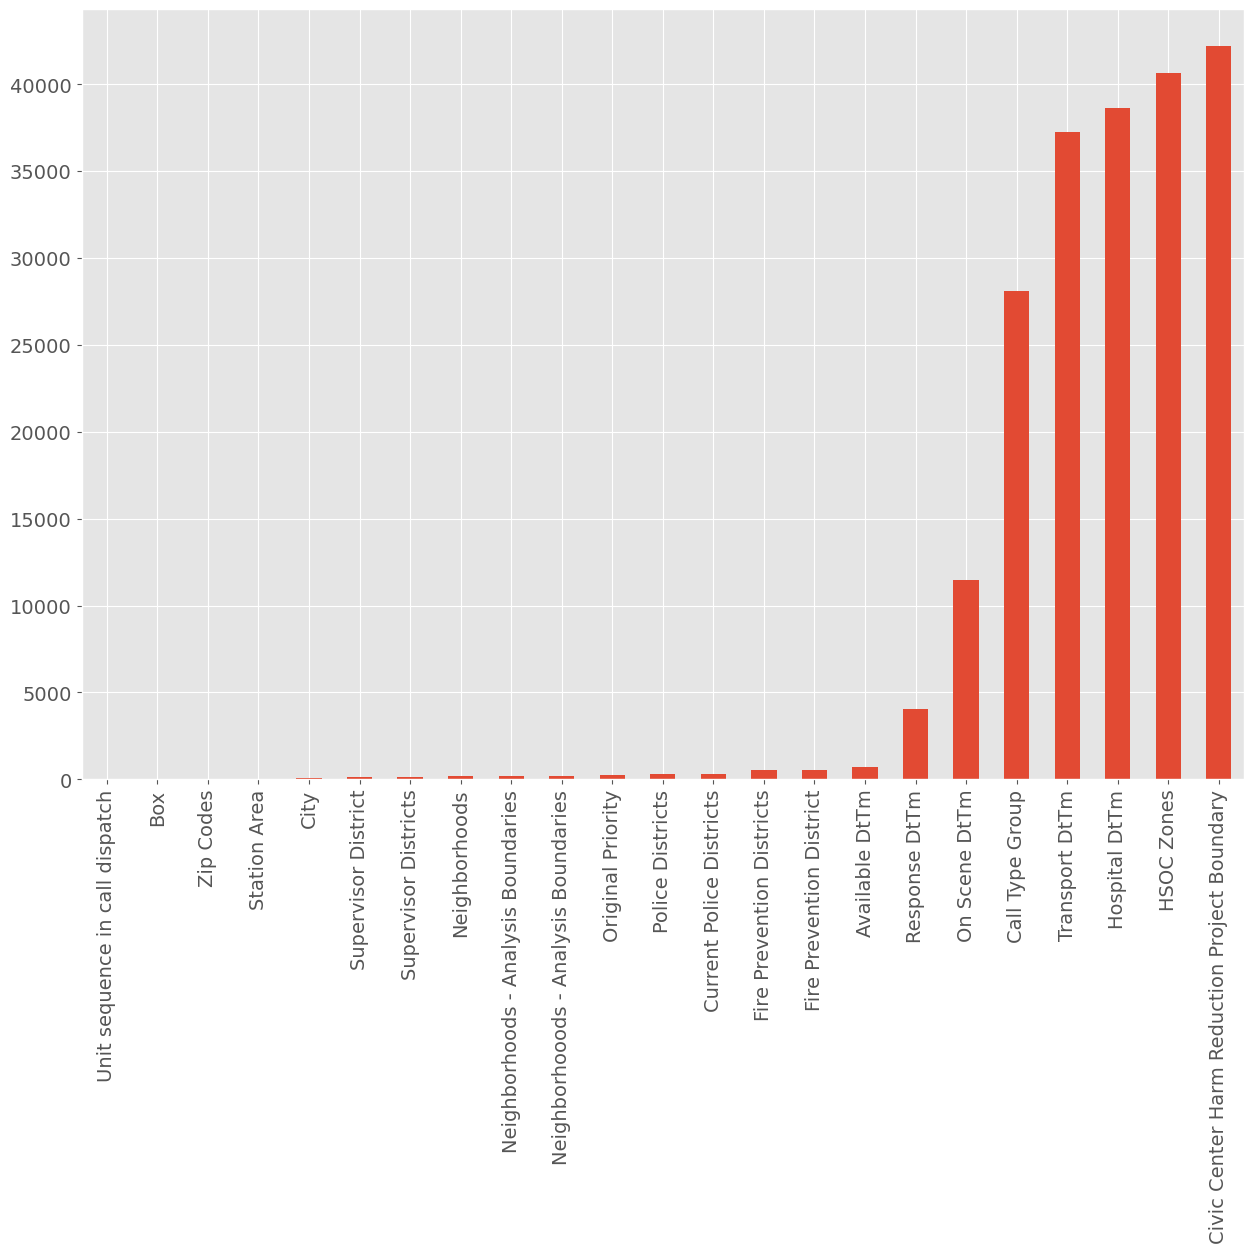

In [24]:
na_col = calls_data.isnull().sum()
na_col = na_col[na_col.values>0]
na_col = na_col.sort_values()
na_col.plot(kind='bar')

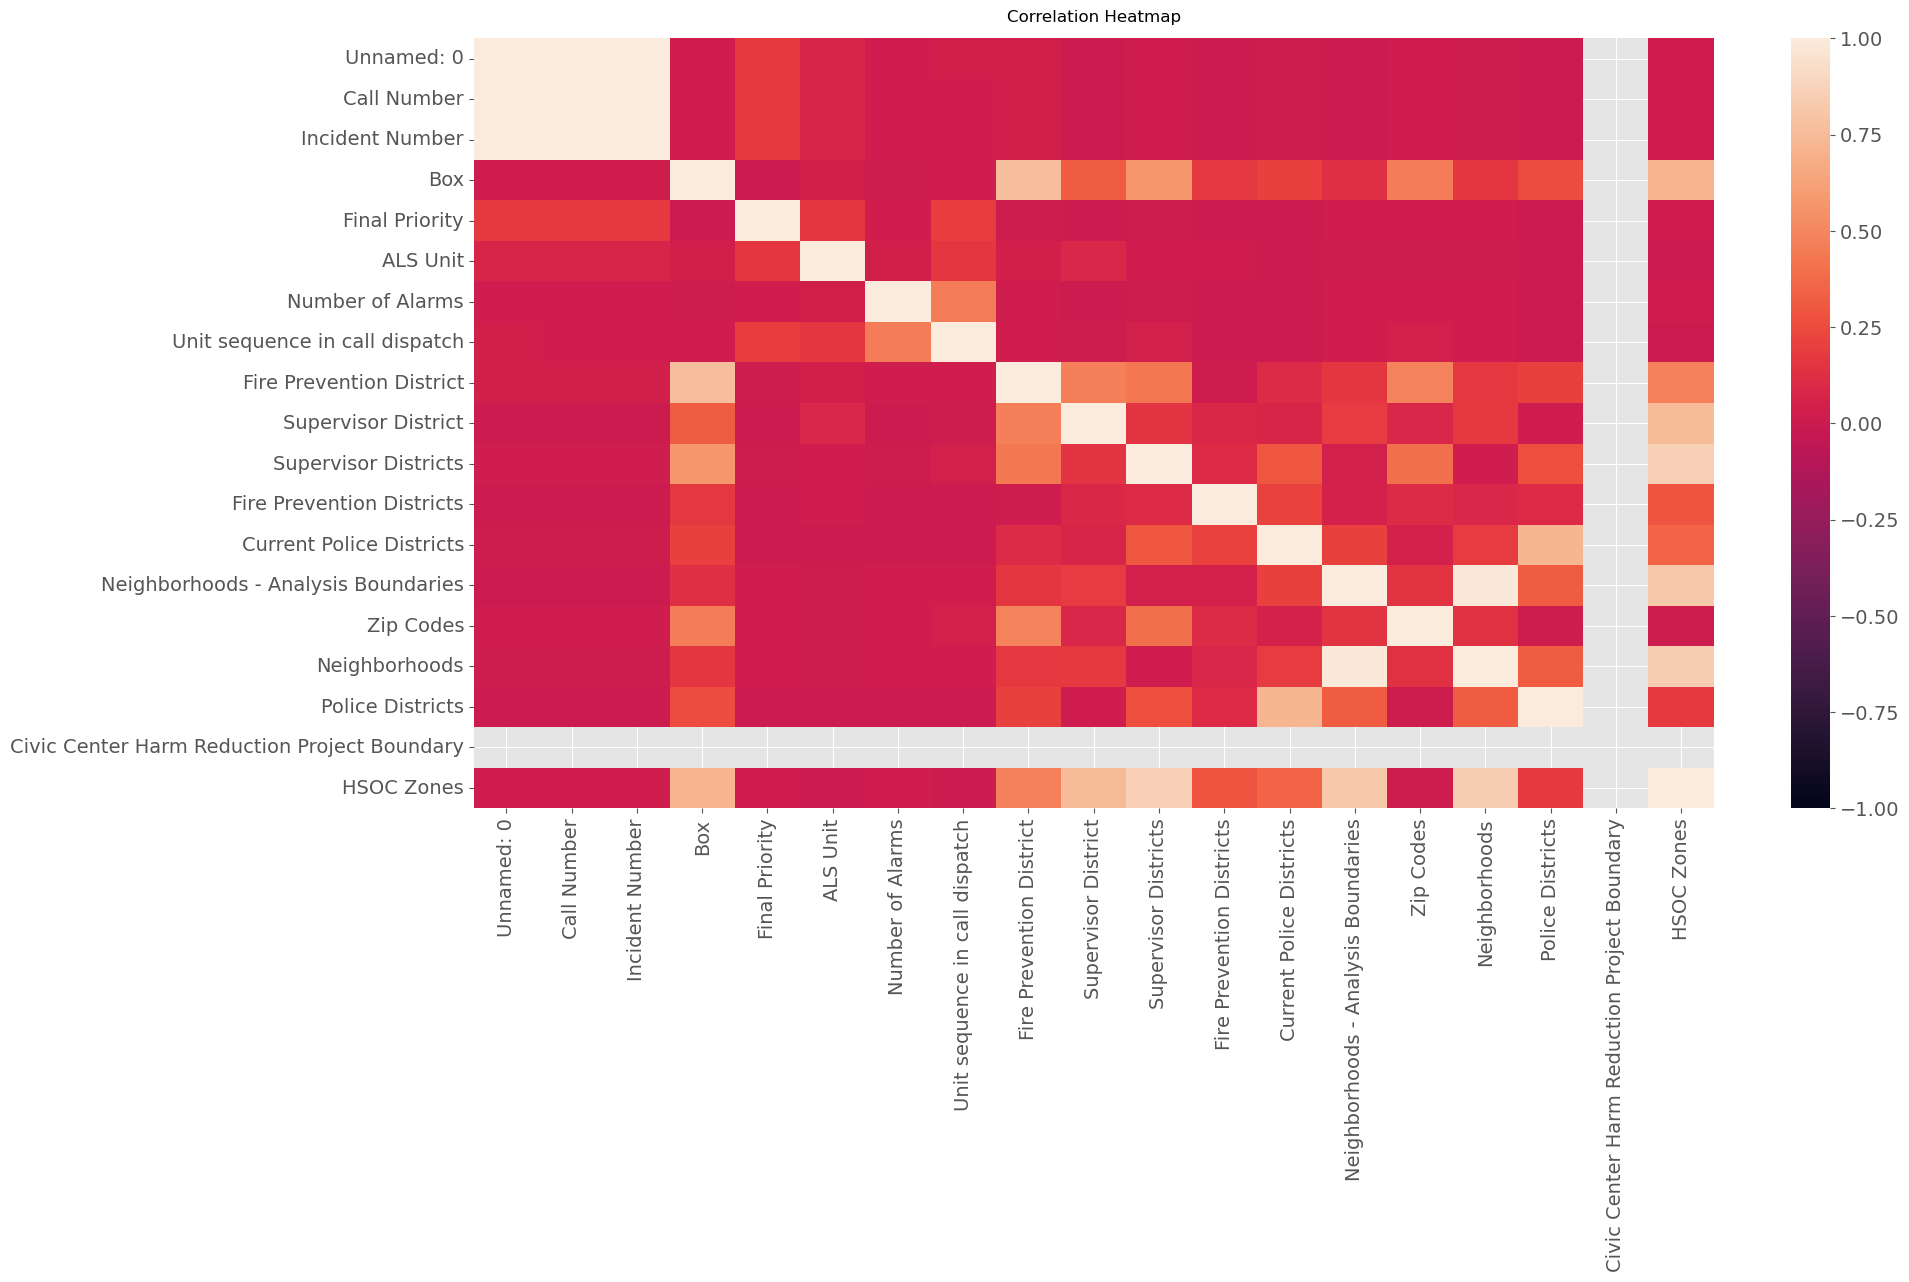

In [36]:
corr_matrix = calls_data.corr(numeric_only=True).abs()
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


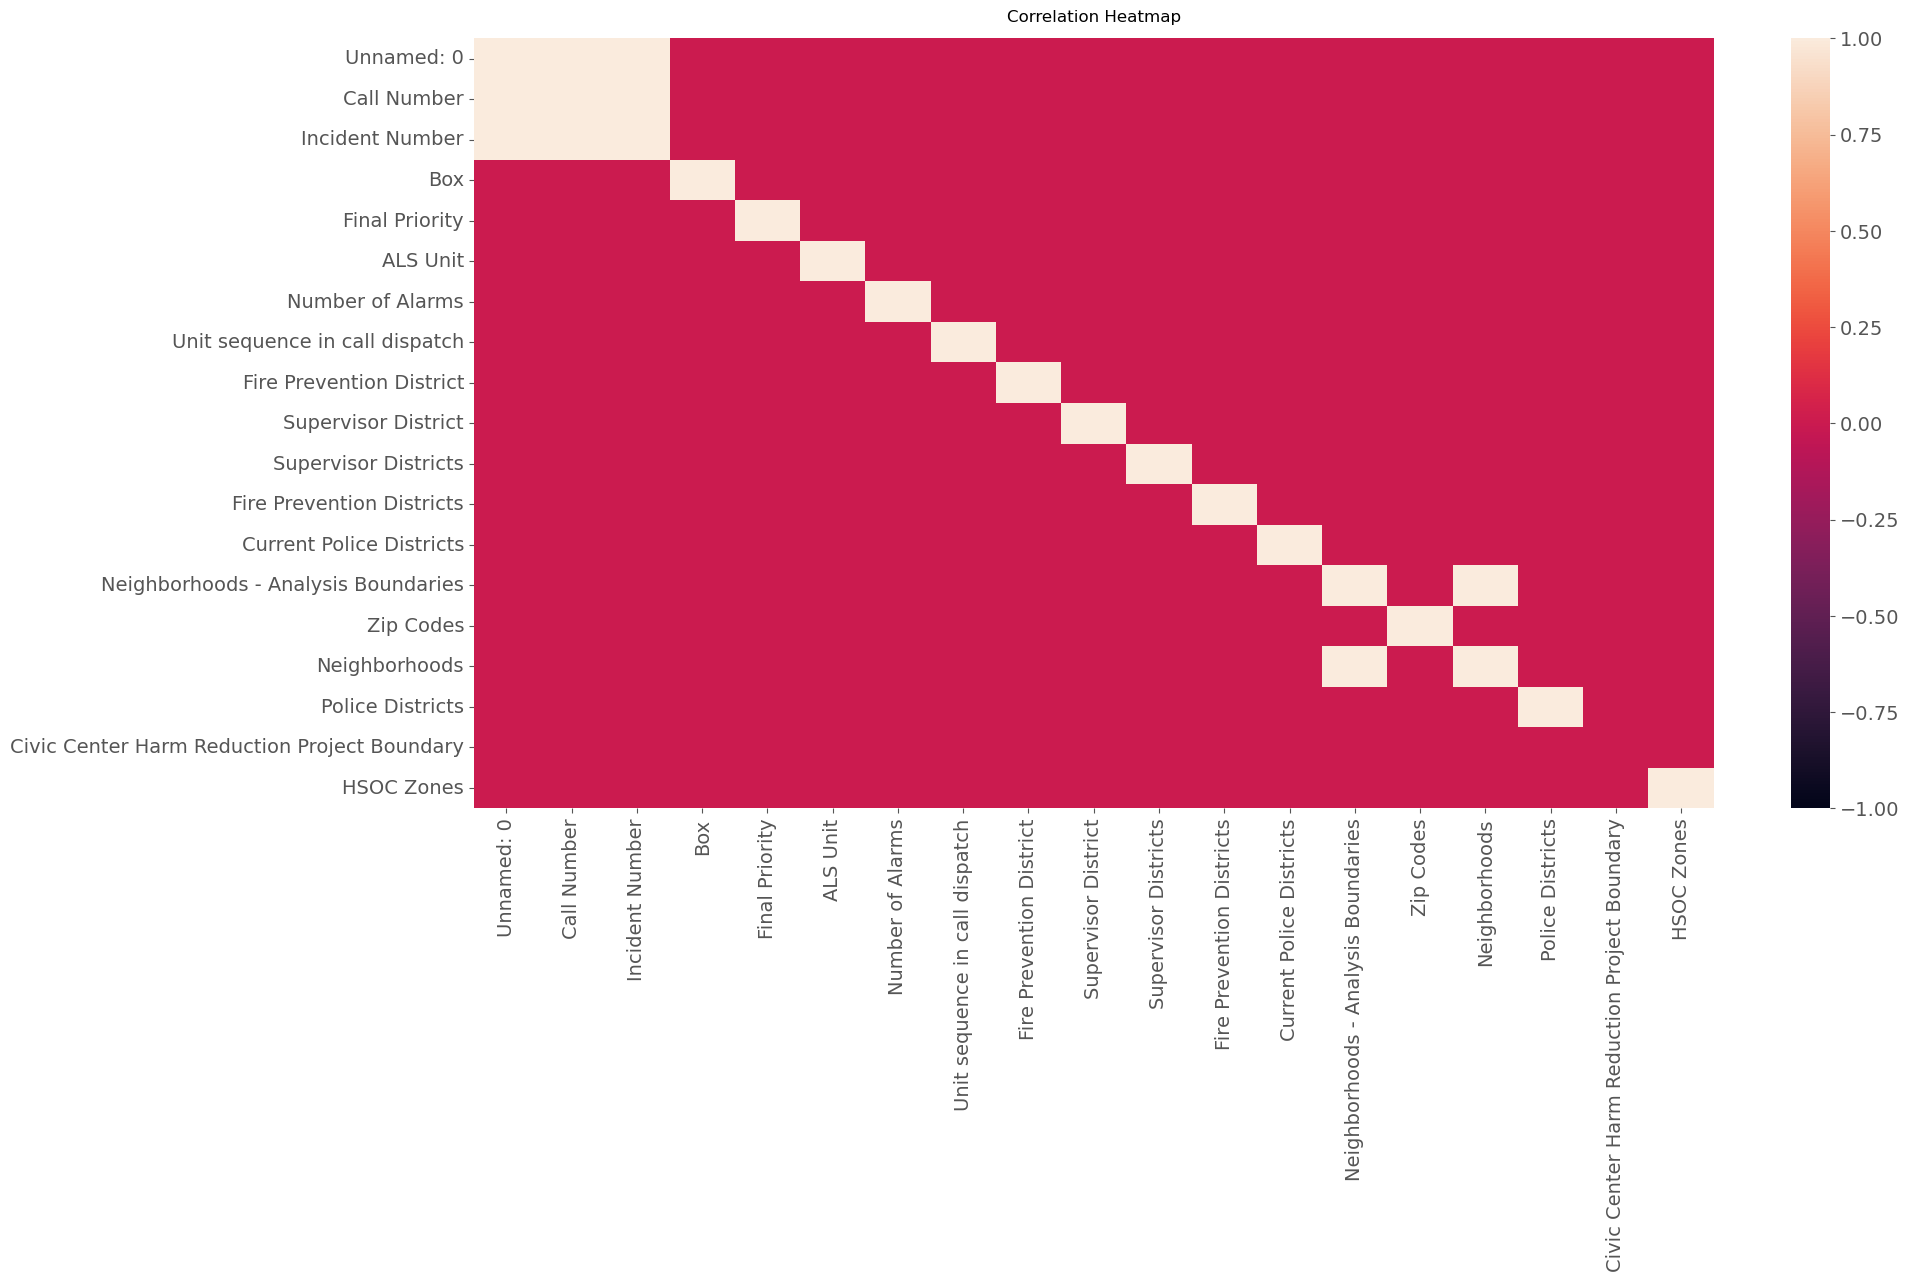

In [37]:
high_corr = corr_matrix>.9
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(high_corr, vmin=-1, vmax=1, annot=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## As we can see :
* high Correlation between ("Unnamed: 0","Call Number","Incident Number") we will keep "Call Number" column
* there is to columns ("Zipcode of Incident" ,"Zip Codes","HSOC Zones") we will keep "Zipcode of Incident" column 
* high Correlation between ("Neighborhoods", "Neighborhoods - Analysis Boundaries") we wil drop "Neighborhoods - Analysis Boundaries" column
* "Civic Center Harm Reduction Project Boundary" is almost null column we can drop it also

In [38]:
drop_columns = ['Civic Center Harm Reduction Project Boundary',
                         'Unnamed: 0',
                         "Incident Number",
                         "Zip Codes",
                         "Neighborhoods - Analysis Boundaries",
                ]

In [39]:
constant_features = get_constant_features(calls_data,threshold=.9)
constant_features

Desc               Var  Value       Perc
0  Quasi Constant  Number of Alarms      1  99.572582

In [40]:
drop_columns.append("Number of Alarms")
calls_data.drop(columns=drop_columns,inplace=True)

# Q1 : From the data, what can we learn from the geography or distribution of the calls ?

In [41]:
def split_location(row):
    location = row["Location"].split(",")
    lat = float(location[0][1:])
    long = float(location[1][:-1])
    return [lat,long]

calls_data[["lat","long"]]=calls_data.progress_apply(split_location,axis=1,result_type="expand")


  0%|          | 0/50536 [00:00<?, ?it/s]

100%|██████████| 50536/50536 [00:01<00:00, 40796.75it/s]


* I get SanFrancisco ZIP Codes geojson data from the following [link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/San-Francisco-ZIP-Codes/srq6-hmpi)

* I get SanFrancisco Neighborhoods geojson data from the following [link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h)

In [42]:
calls_per_zip = calls_data.groupby("Zipcode of Incident").agg({"Call Number":"count"}).reset_index()
geo=r"San Francisco ZIP Codes.geojson"
file = open(geo, encoding="utf8")
geo_json_zip = file.read()

In [46]:
zip_calls_map = folium.Map(location=[37.7749, -122.4194],tiles="Cartodb Positron",     
                        zoom_start=12,
                        width="100%",
                        height="100%")
choropleth=folium.Choropleth(
    geo_data=geo_json_zip,
    data=calls_per_zip,
    columns=['Zipcode of Incident','Call Number'],   
    key_on='feature.properties.zip_code', 
    highlight =True
    ).add_to(zip_calls_map)

folium.LayerControl().add_to(zip_calls_map)  
choropleth.geojson.add_child(  
    folium.features.GeoJsonTooltip(['zip_code'], labels=False)  
)

zip_calls_map

<Axes: ylabel='Zipcode of Incident'>

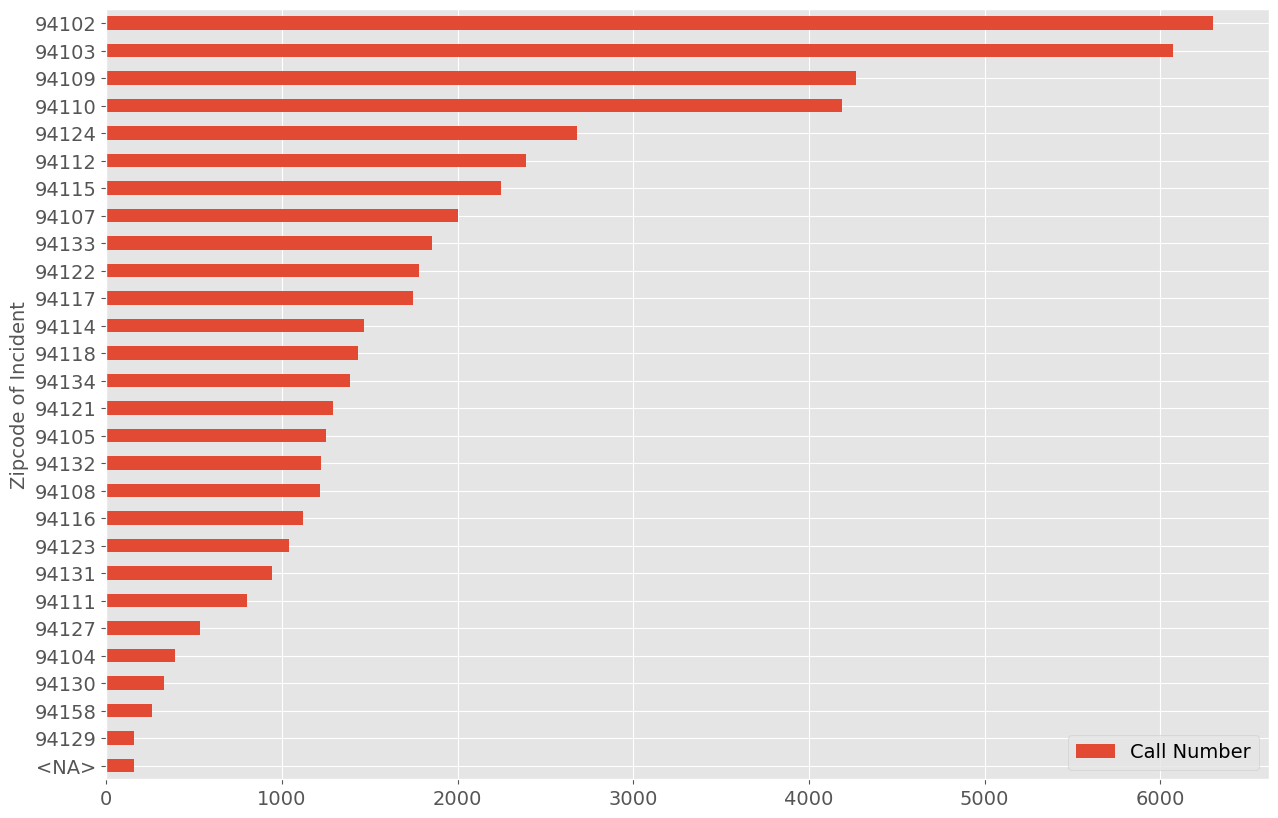

In [47]:
calls_per_zip.sort_values("Call Number").set_index("Zipcode of Incident").plot(kind="barh")

In [48]:
calls_per_hood = calls_data.groupby("Neighborhooods - Analysis Boundaries").agg({"Call Number":"count"}).reset_index()
geo=r"Analysis Neighborhoods.geojson"
file = open(geo, encoding="utf8")
geo_json_hood = file.read()

In [50]:
hood_calls_map = folium.Map(location=[37.7749, -122.4194],tiles="Cartodb Positron",     
                        zoom_start=12,
                        width="100%",
                        height="100%")
choropleth=folium.Choropleth(
    geo_data=geo_json_hood,
    data=calls_per_hood,
    columns=['Neighborhooods - Analysis Boundaries','Call Number'],   
    key_on='feature.properties.nhood', 
    highlight =True
    ).add_to(hood_calls_map)

folium.LayerControl().add_to(hood_calls_map)  
choropleth.geojson.add_child(  
    folium.features.GeoJsonTooltip(['nhood'], labels=False)  
)

hood_calls_map

<Axes: >

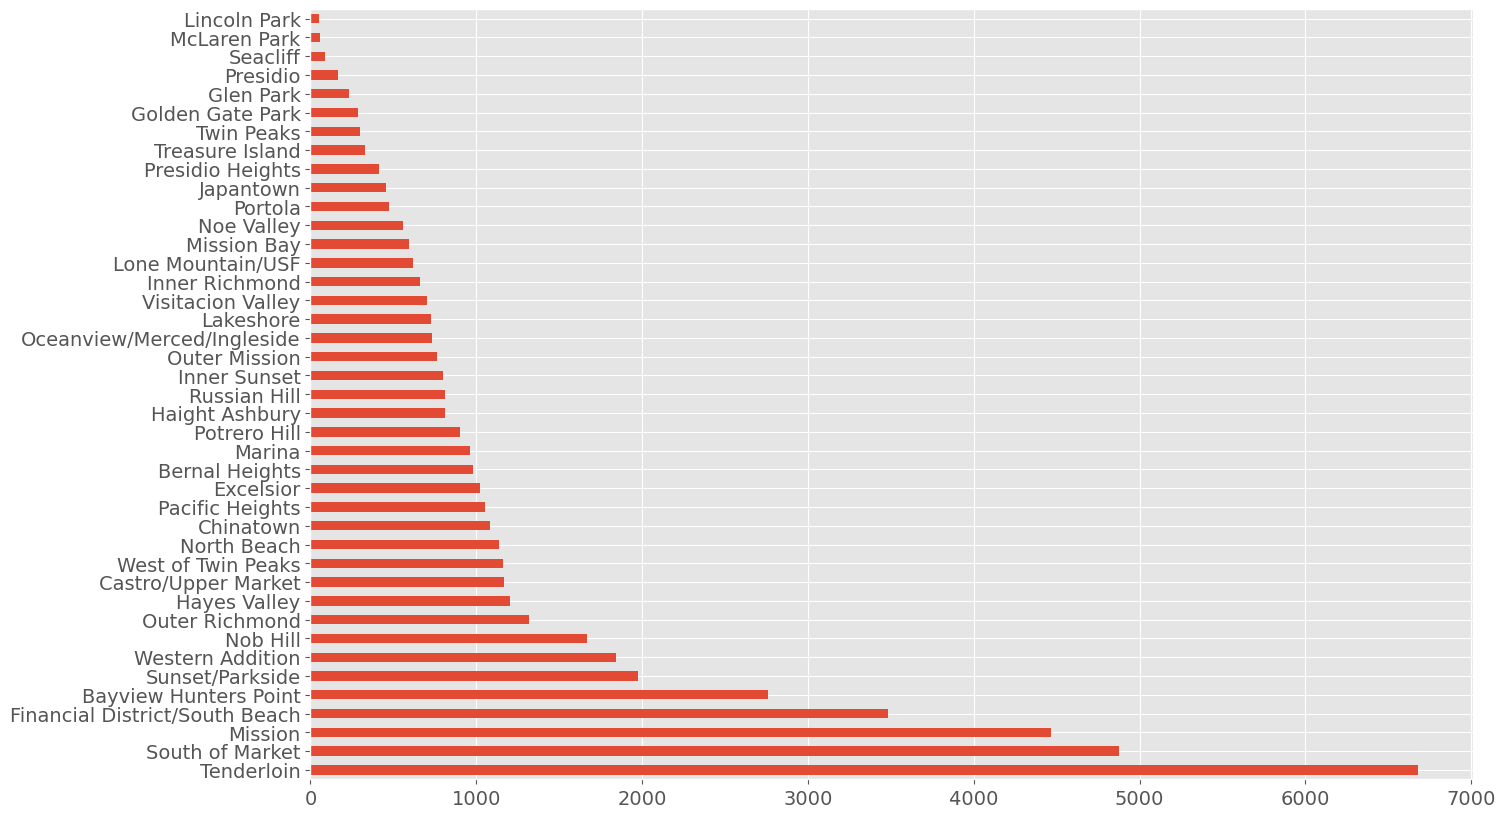

In [51]:
calls_data["Neighborhooods - Analysis Boundaries"].value_counts().plot(kind='barh')

# Q2 : Are there any immediate trends you can identify for the reasons for calls ?

<Axes: ylabel='Call Type'>

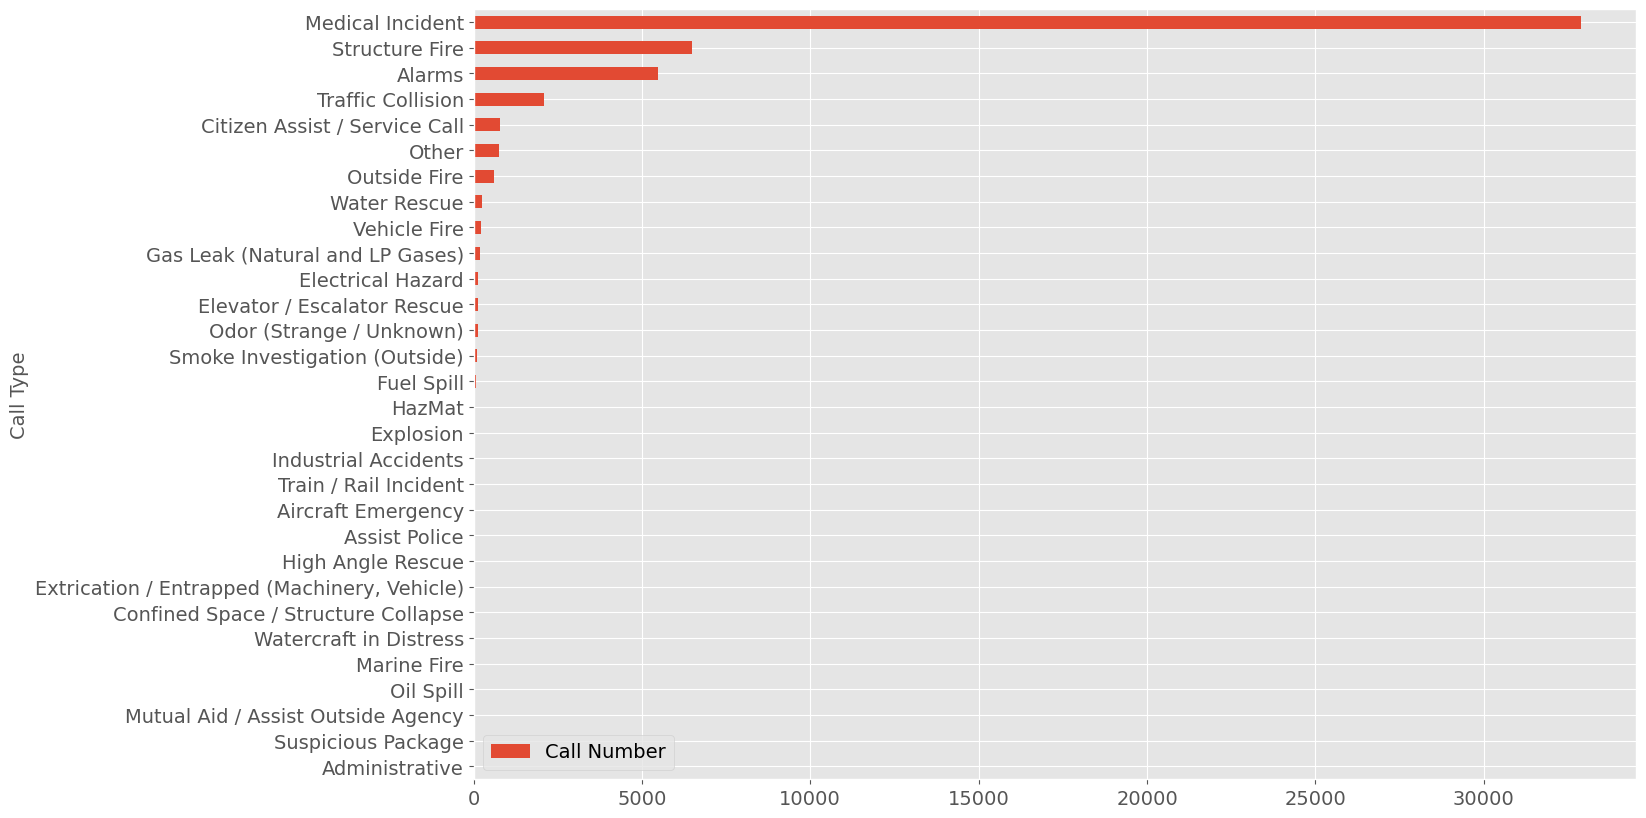

In [52]:
calls_type = calls_data.groupby("Call Type").agg({"Call Number":"count"}).sort_values(by=["Call Number"])
calls_type.plot(kind='barh')

<Axes: >

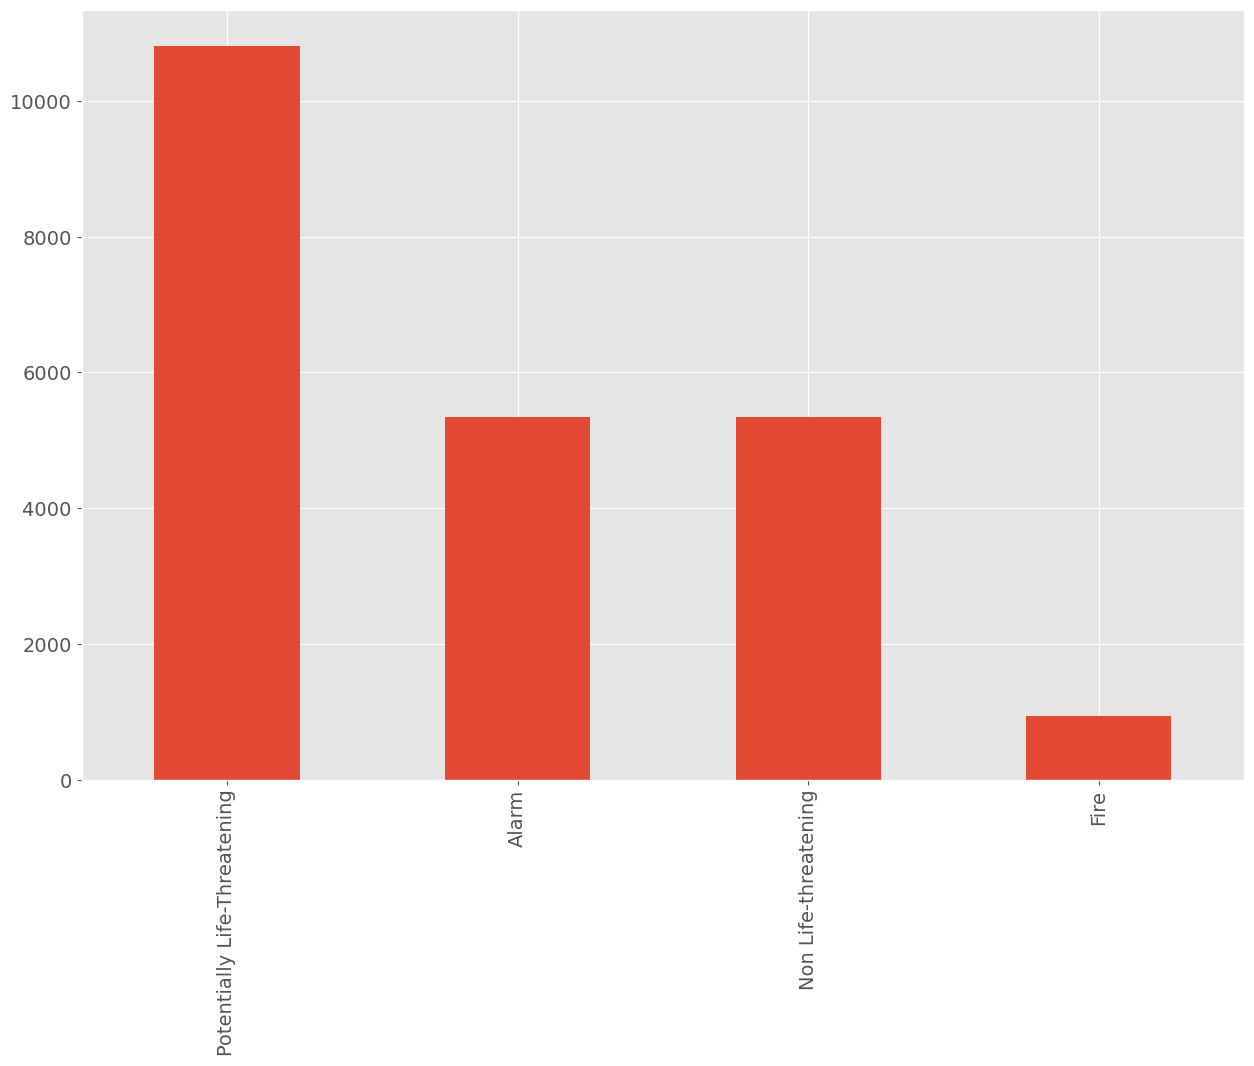

In [53]:
calls_data["Call Type Group"].value_counts().plot(kind='bar')

In [54]:
calls_data["call_hour"] = calls_data['Received DtTm'].dt.hour
calls_data["call_dow"] = calls_data['Received DtTm'].dt.day_name()
calls_data["call_month"] = calls_data['Received DtTm'].dt.month
calls_data["call_year"] = calls_data['Received DtTm'].dt.year
calls_data["call_day"] = calls_data['Received DtTm'].dt.day

<Axes: xlabel='call_hour'>

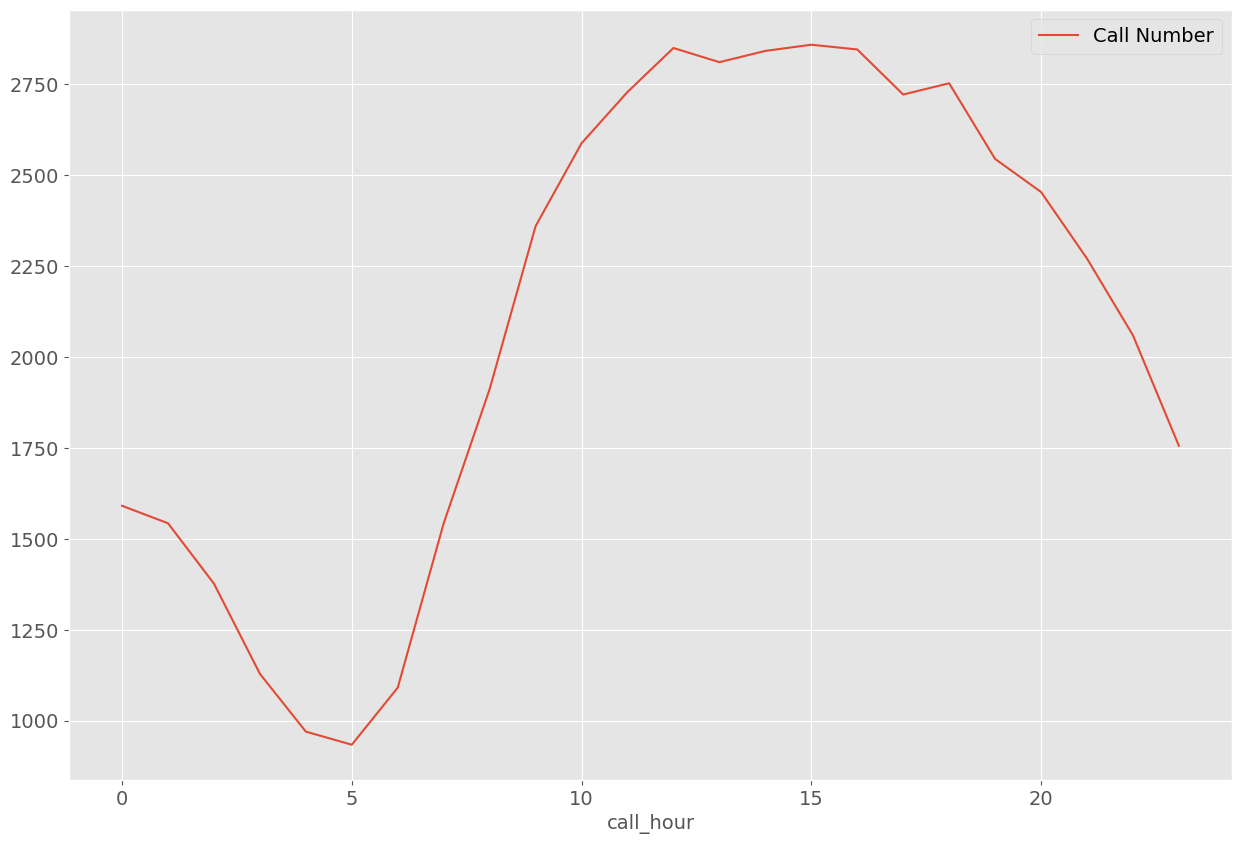

In [55]:
calls_hours = calls_data.groupby("call_hour").agg({"Call Number":"count"})
calls_hours.plot(kind='line')

In [56]:
comman_call_type = calls_data["Call Type"].value_counts()
comman_call_type = comman_call_type[comman_call_type>1000].index.to_list()


<Axes: xlabel='call_hour'>

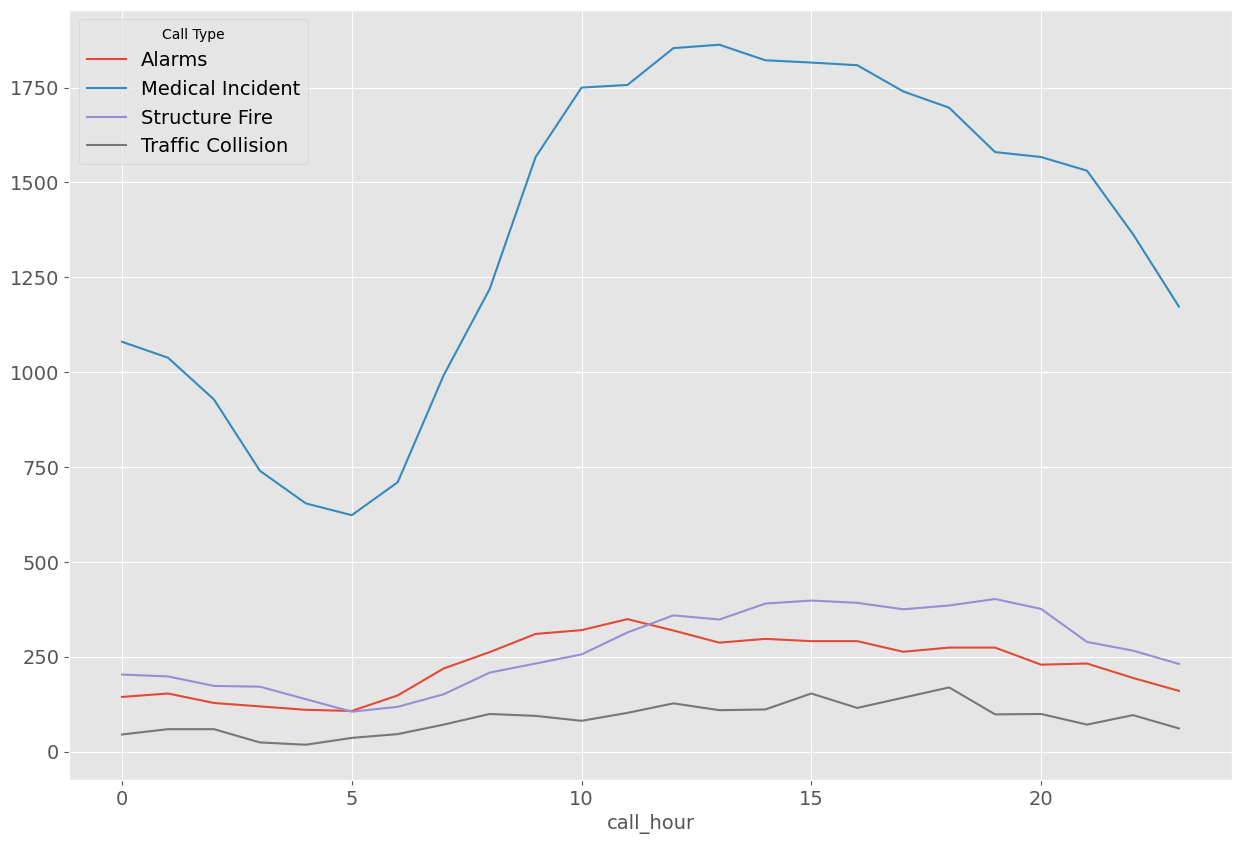

In [57]:
types_calls_per_hour = pd.pivot_table(calls_data[calls_data["Call Type"].isin(comman_call_type)==True]
                                      ,index="call_hour",columns="Call Type",values="Call Number",
                                      aggfunc="count")

types_calls_per_hour.plot()

<Axes: xlabel='call_dow'>

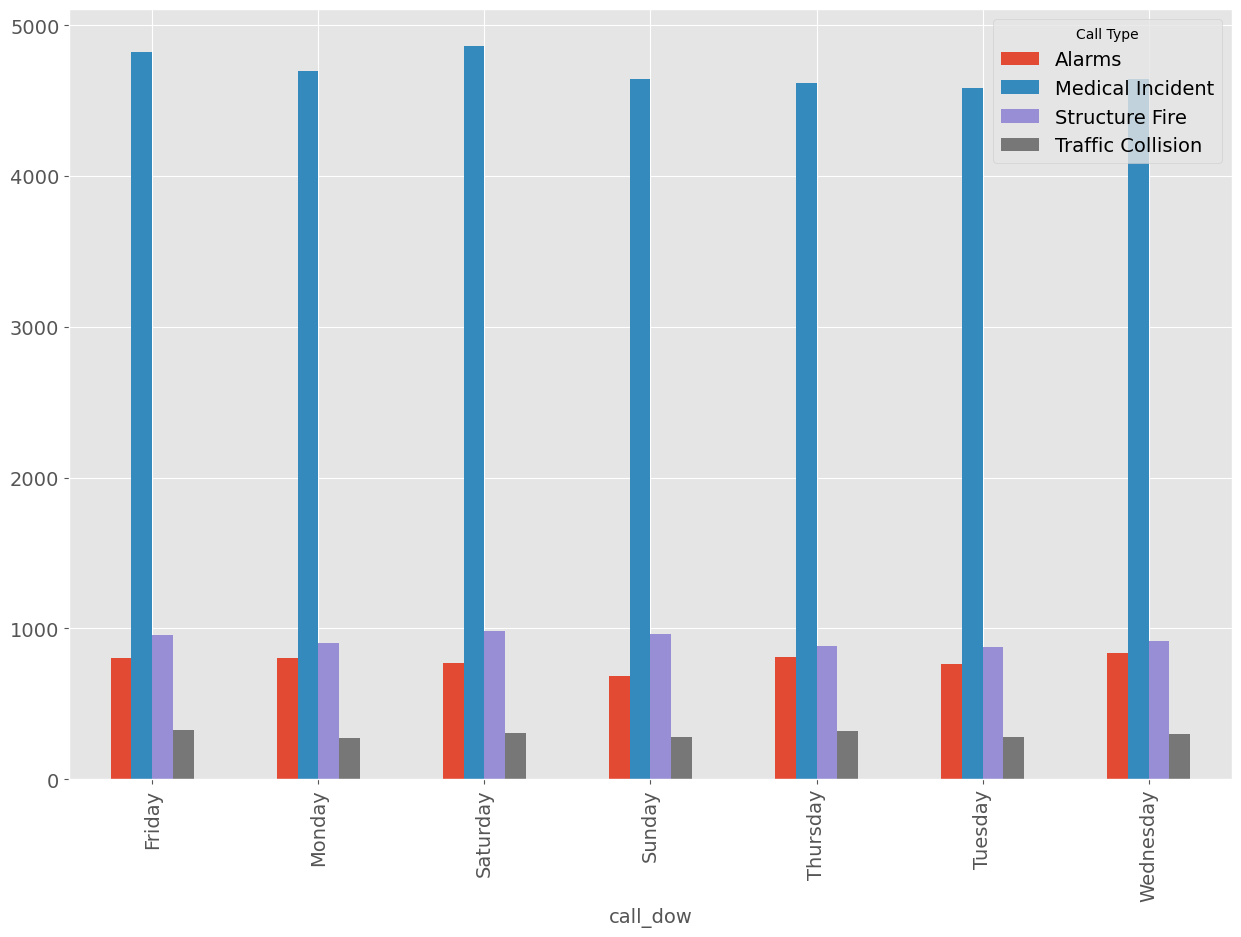

In [58]:
types_calls_per_dow = pd.pivot_table(calls_data[calls_data["Call Type"].isin(comman_call_type)==True]
                                      ,index="call_dow",columns="Call Type",values="Call Number",
                                      aggfunc="count")
types_calls_per_dow.plot(kind='bar')

<Axes: xlabel='call_month'>

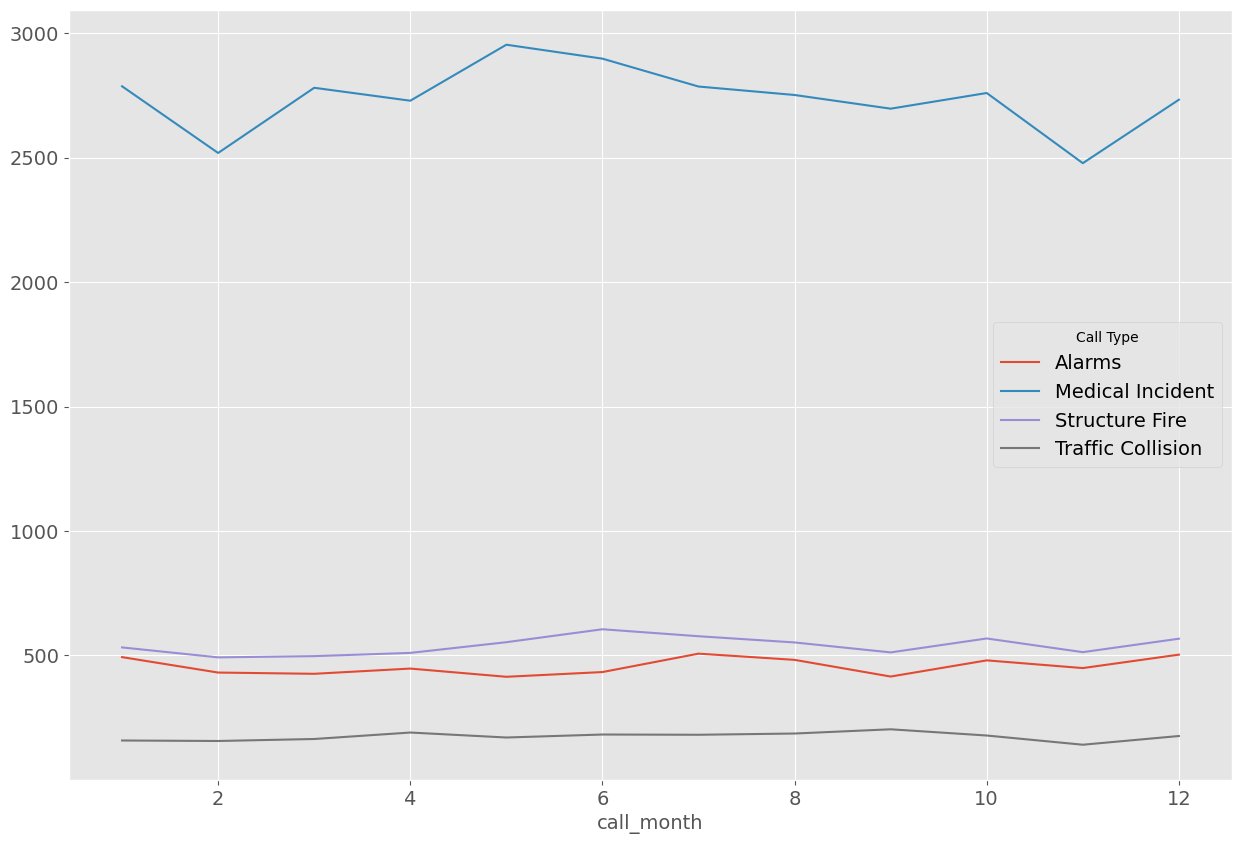

In [59]:
types_calls_per_month = pd.pivot_table(calls_data[calls_data["Call Type"].isin(comman_call_type)==True]
                                      ,index="call_month",columns="Call Type",values="Call Number",
                                      aggfunc="count")

types_calls_per_month.plot()

<Axes: xlabel='call_day'>

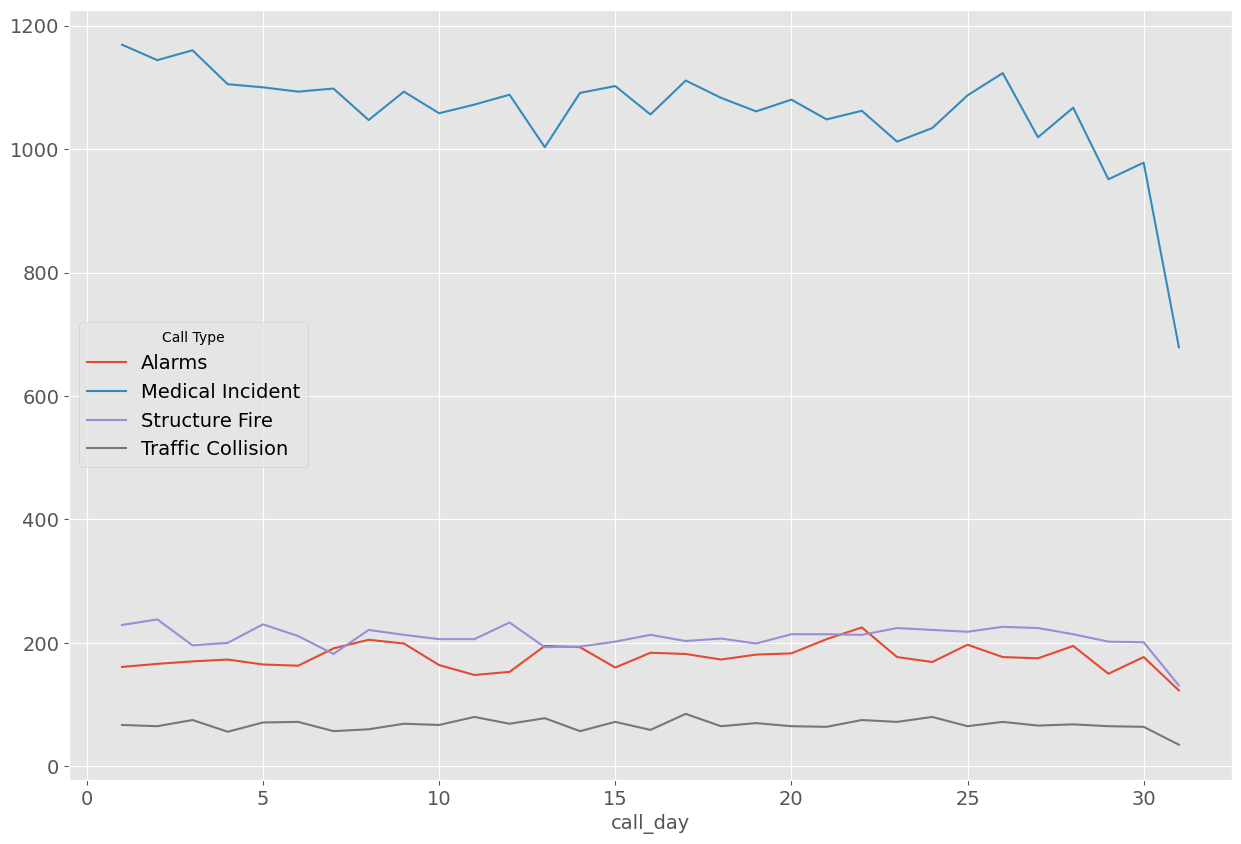

In [60]:
types_calls_per_day = pd.pivot_table(calls_data[calls_data["Call Type"].isin(comman_call_type)==True]
                                      ,index="call_day",columns="Call Type",values="Call Number",
                                      aggfunc="count")
types_calls_per_day.plot()

<Axes: xlabel='call_year'>

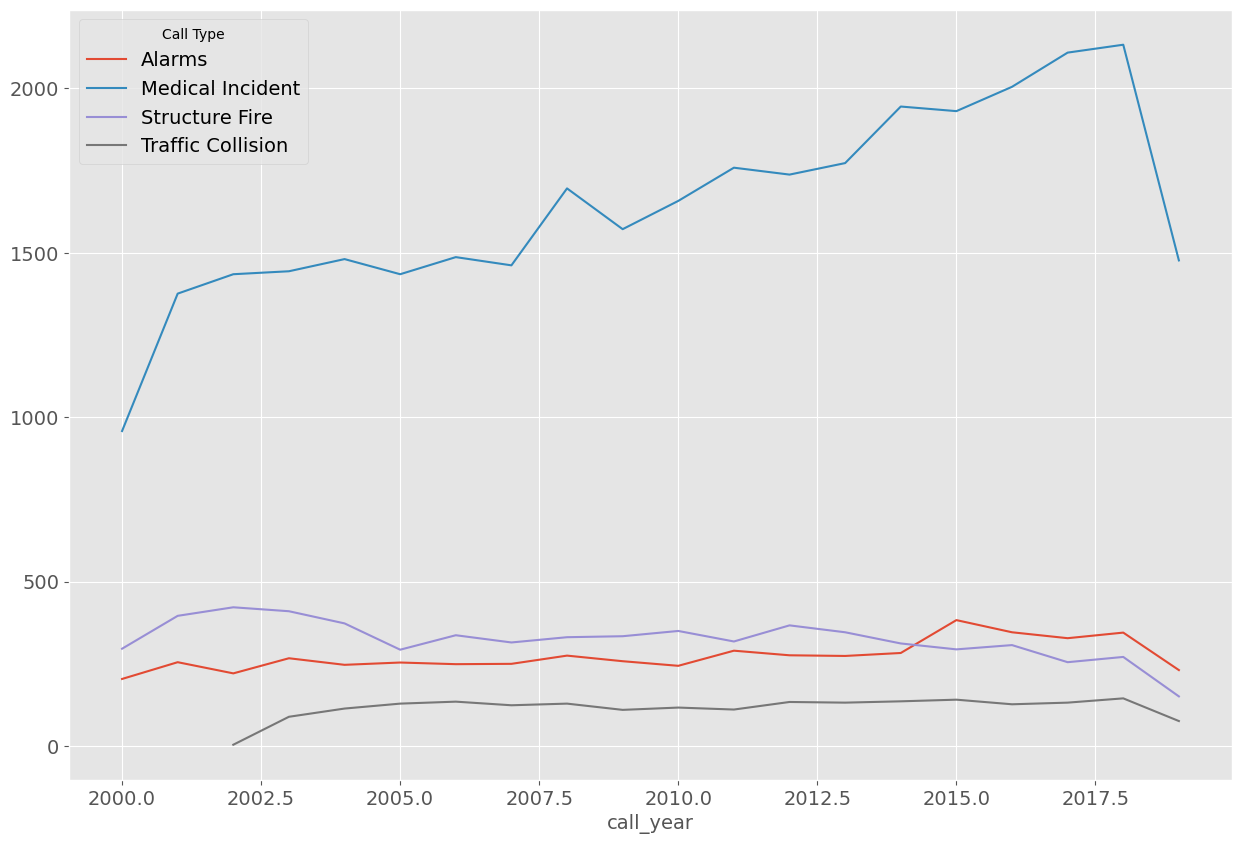

In [61]:
types_calls_per_year = pd.pivot_table(calls_data[calls_data["Call Type"].isin(comman_call_type)==True]
                                      ,index="call_year",columns="Call Type",values="Call Number",
                                      aggfunc="count")
types_calls_per_year.plot()

# Q3 : The dataset gives a priority for the call but what does the rest of the data say about priority? Where are you most likely to have a delay in receiving help or getting to a hospital ?

In [62]:
calls_data["received_to_Response"]= (calls_data['Response DtTm']-calls_data['Received DtTm']).astype('timedelta64[m]').fillna(0)
calls_data["Response_to_scene"]= (calls_data['On Scene DtTm']-calls_data['Response DtTm']).astype('timedelta64[m]').fillna(0)
calls_data["transport_to_hospital"]= (calls_data['Hospital DtTm']-calls_data['Transport DtTm']).astype('timedelta64[m]').fillna(0)
calls_data["received_to_scene"]= (calls_data['On Scene DtTm']-calls_data['Received DtTm']).astype('timedelta64[m]').fillna(0)

C:\Users\Mahmo\AppData\Local\Temp\ipykernel_14328\1679537554.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(calls_data.corr()[['received_to_Response']].sort_values(by='received_to_Response', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')


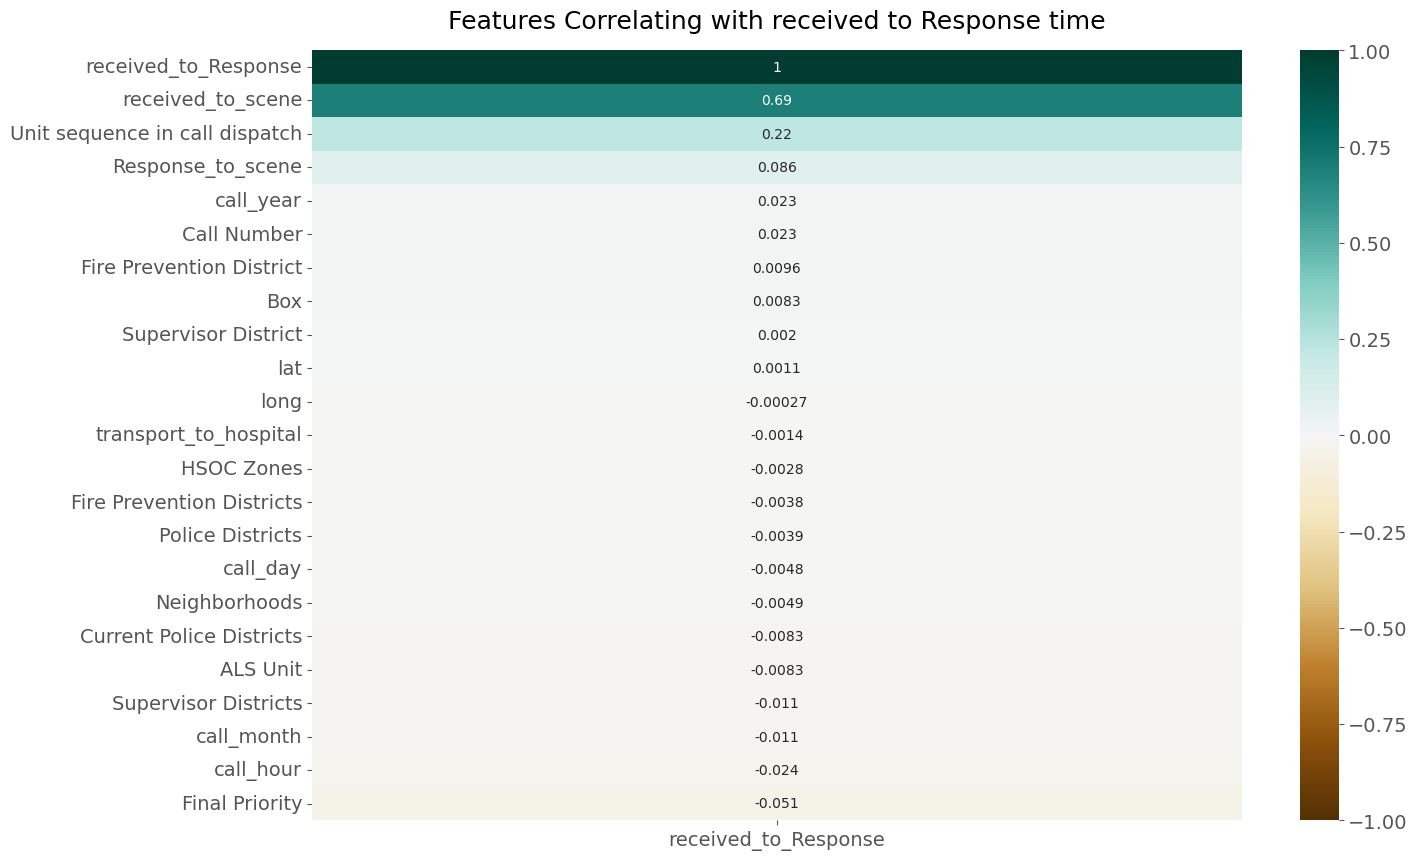

In [63]:
heatmap = sns.heatmap(calls_data.corr()[['received_to_Response']].sort_values(by='received_to_Response', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with received to Response time', fontdict={'fontsize':18}, pad=16);

C:\Users\Mahmo\AppData\Local\Temp\ipykernel_14328\721098573.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(calls_data.corr()[['Response_to_scene']].sort_values(by='Response_to_scene', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')


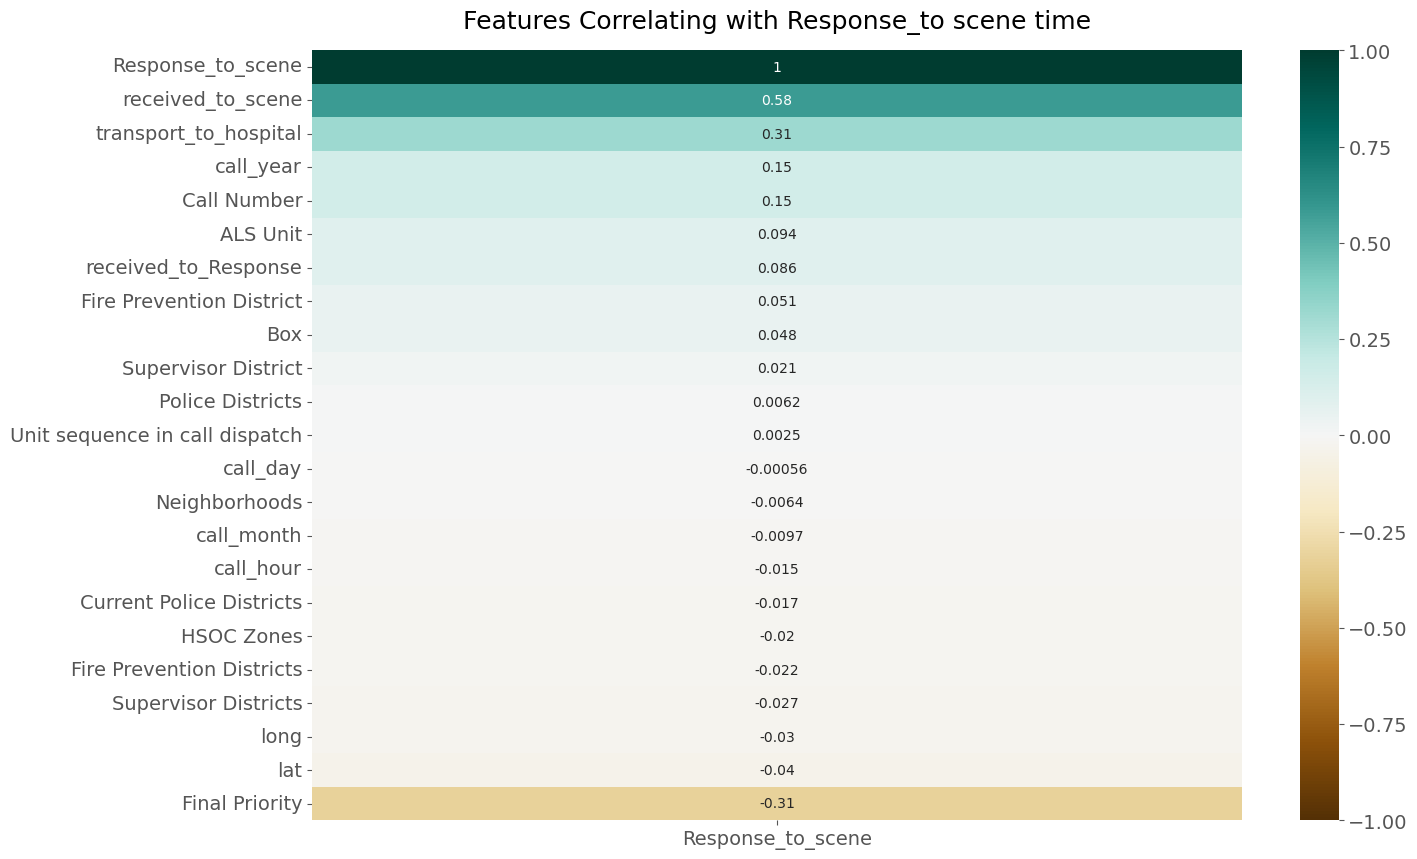

In [64]:
#https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
heatmap = sns.heatmap(calls_data.corr()[['Response_to_scene']].sort_values(by='Response_to_scene', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Response_to scene time', fontdict={'fontsize':18}, pad=16);

C:\Users\Mahmo\AppData\Local\Temp\ipykernel_14328\3288205526.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(calls_data.corr()[['transport_to_hospital']].sort_values(by='transport_to_hospital', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')


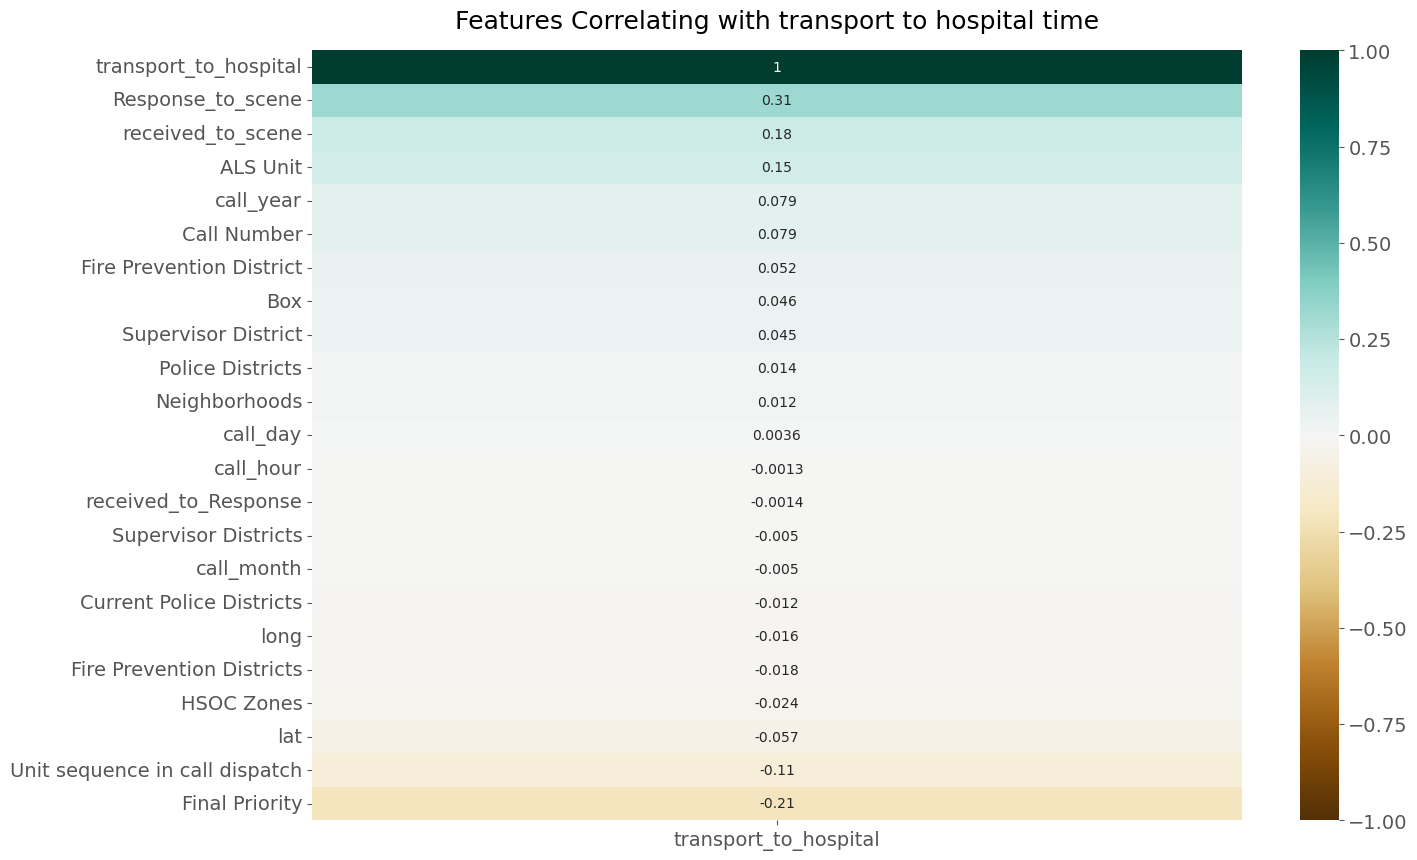

In [65]:
heatmap = sns.heatmap(calls_data.corr()[['transport_to_hospital']].sort_values(by='transport_to_hospital', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with transport to hospital time', fontdict={'fontsize':18}, pad=16);

## Removing outliers : 

In [66]:
q_low = calls_data["received_to_scene"].quantile(0.01)
q_hi  = calls_data["received_to_scene"].quantile(0.99)
calls_data = calls_data[(calls_data["received_to_scene"] < q_hi) & (calls_data["received_to_scene"] > q_low)]

<Axes: xlabel='Final Priority', ylabel='received_to_scene'>

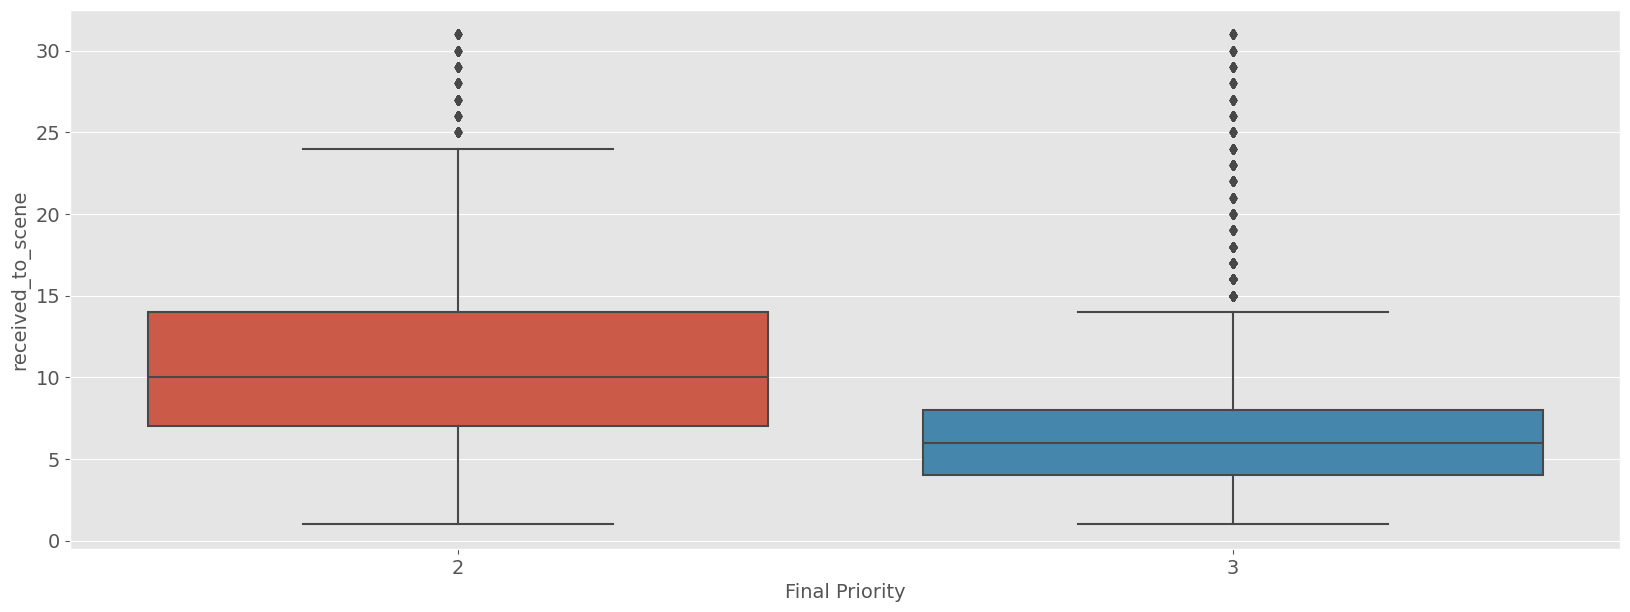

In [67]:
delay_per_priority  = calls_data[calls_data["Final Priority"]!=np.nan][["Final Priority","received_to_scene"]]
plt.figure(figsize=[20,7],)
sns.boxplot(data=delay_per_priority,x='Final Priority', y='received_to_scene')

<Axes: xlabel='Zipcode of Incident', ylabel='received_to_scene'>

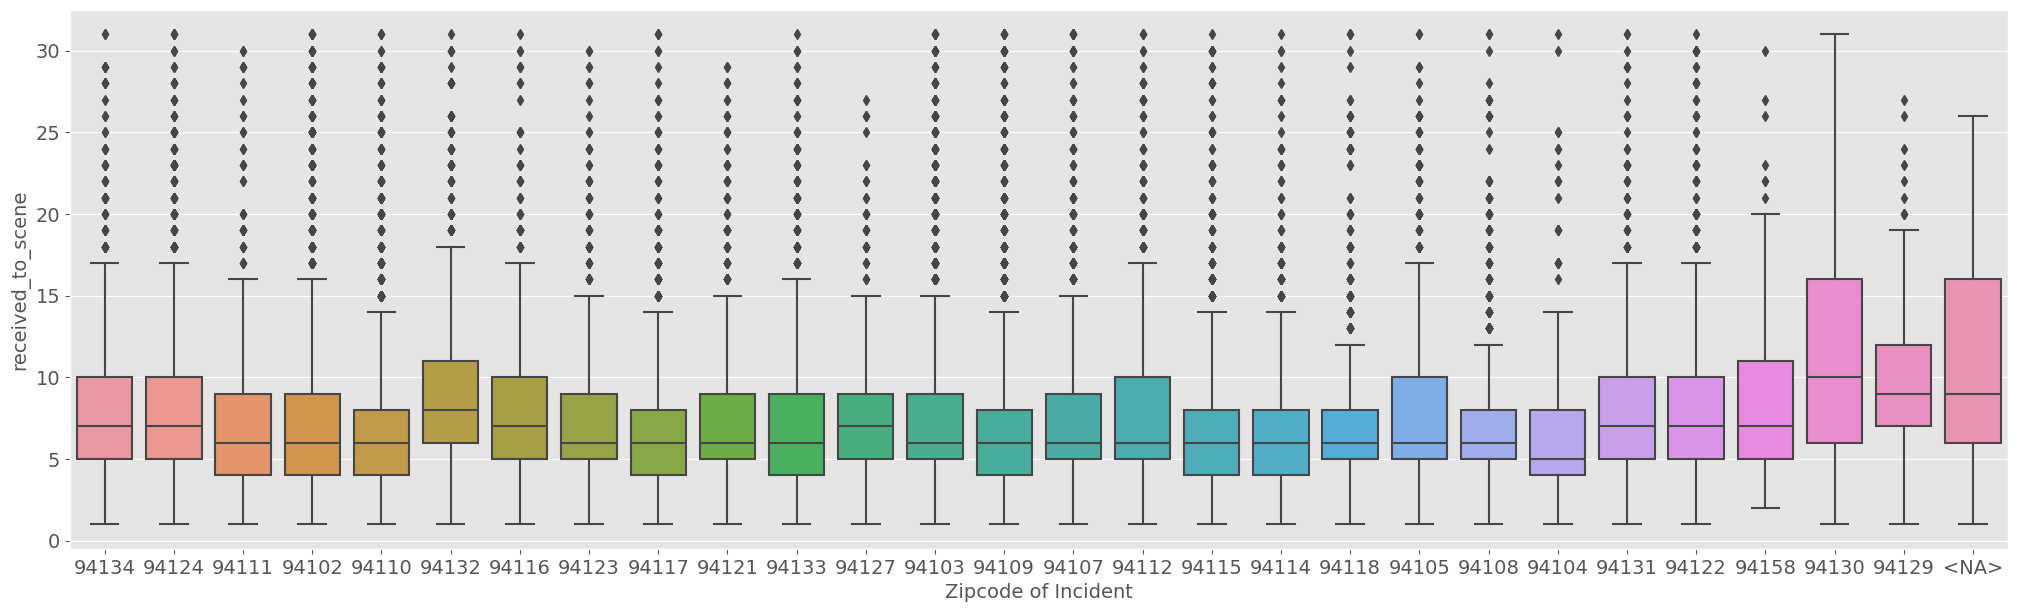

In [68]:
delay_per_zip = calls_data[calls_data["Zipcode of Incident"]!=np.nan][["Zipcode of Incident","received_to_scene"]]
delay_per_zip["Zipcode of Incident"]=delay_per_zip["Zipcode of Incident"].astype(str)
plt.figure(figsize=[25,7],)
sns.boxplot(data=delay_per_zip,x='Zipcode of Incident', y='received_to_scene')

<Axes: xlabel='Zipcode of Incident'>

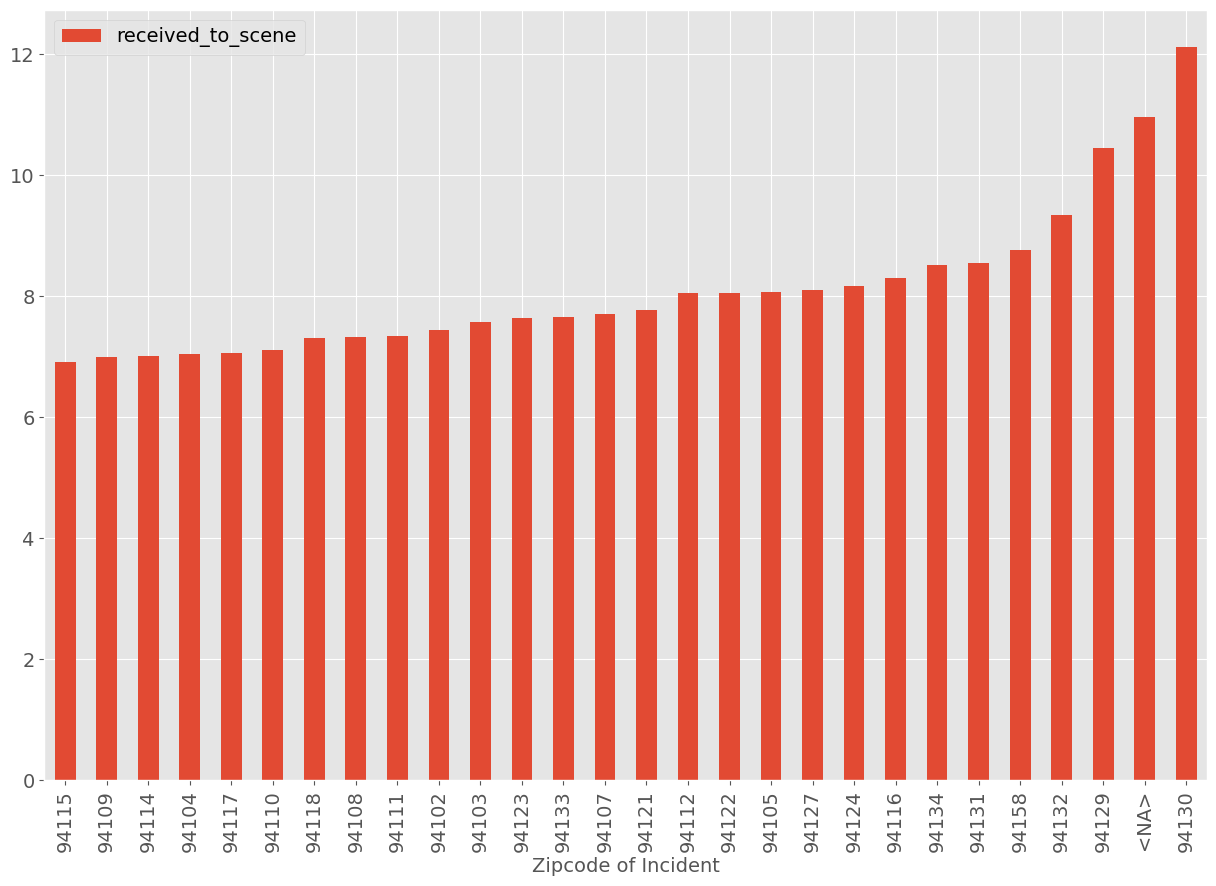

In [69]:
delay_per_zip = delay_per_zip.groupby("Zipcode of Incident").agg({"received_to_scene":"mean"}).sort_values(by=["received_to_scene"])
delay_per_zip.plot(kind='bar')

In [71]:
m = folium.Map(location=[37.7749, -122.4194],tiles="Cartodb Positron",     
                        zoom_start=12,
                        width="100%",
                        height="100%")
choropleth=folium.Choropleth(
    geo_data=geo_json_zip,
    data=delay_per_zip.reset_index(),
    columns=['Zipcode of Incident','received_to_scene'],   
    key_on='feature.properties.zip_code', 
    highlight =True
    ).add_to(m)

folium.LayerControl().add_to(m)
choropleth.geojson.add_child(  
    folium.features.GeoJsonTooltip(['zip_code'], labels=False)  
)

m

<Axes: xlabel='Zipcode of Incident'>

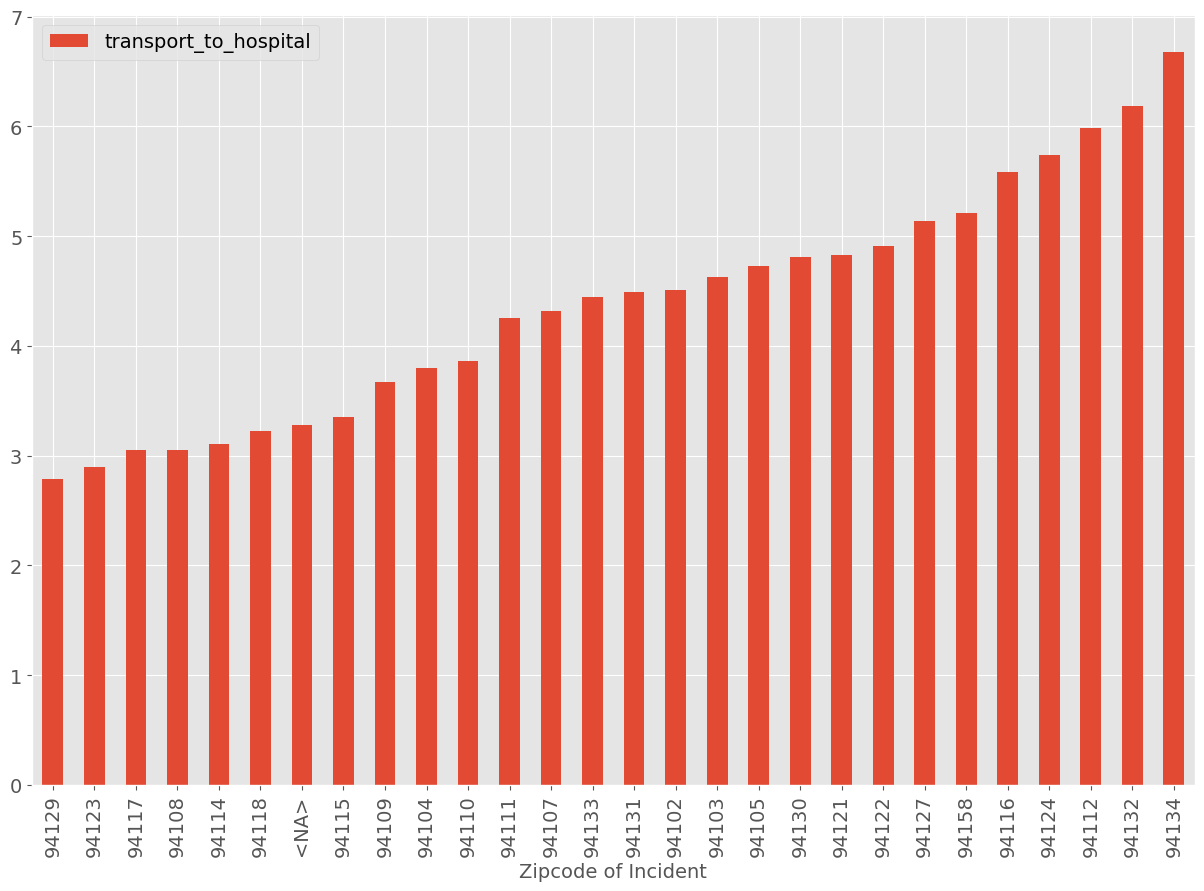

In [72]:
hospital_delay = calls_data[calls_data["Hospital DtTm"]!=np.nan].groupby("Zipcode of Incident").agg({"transport_to_hospital":"mean"}).sort_values(by=["transport_to_hospital"])
hospital_delay.plot(kind='bar')

In [74]:
m = folium.Map(location=[37.7749, -122.4194],tiles="Cartodb Positron",     
                        zoom_start=12,
                        width="100%",
                        height="100%")
choropleth=folium.Choropleth(
    geo_data=geo_json_zip,
    data=hospital_delay.reset_index(),
    columns=['Zipcode of Incident','transport_to_hospital'],   
    key_on='feature.properties.zip_code', 
    highlight =True
    ).add_to(m)

folium.LayerControl().add_to(m)
choropleth.geojson.add_child(  
    folium.features.GeoJsonTooltip(['zip_code'], labels=False)  
)

m

# Q4 : Are calls trending up or down? Tell us how you might use this data to make a decision ?

<Axes: xlabel='call_month,call_year'>

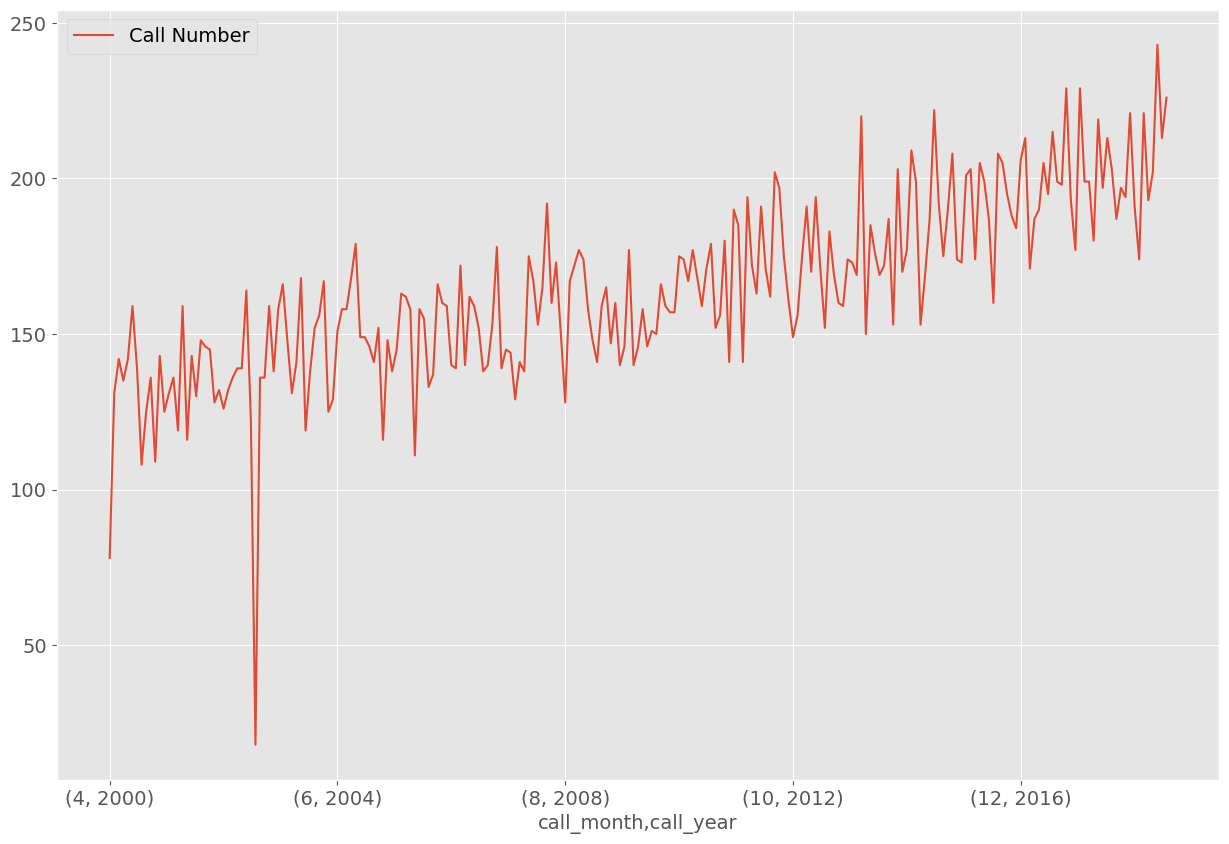

In [75]:
calls = calls_data.groupby(["call_month","call_year"]).agg({"Call Number":"count"}).sort_values(by=["call_year","call_month"])
calls.plot(kind='line')

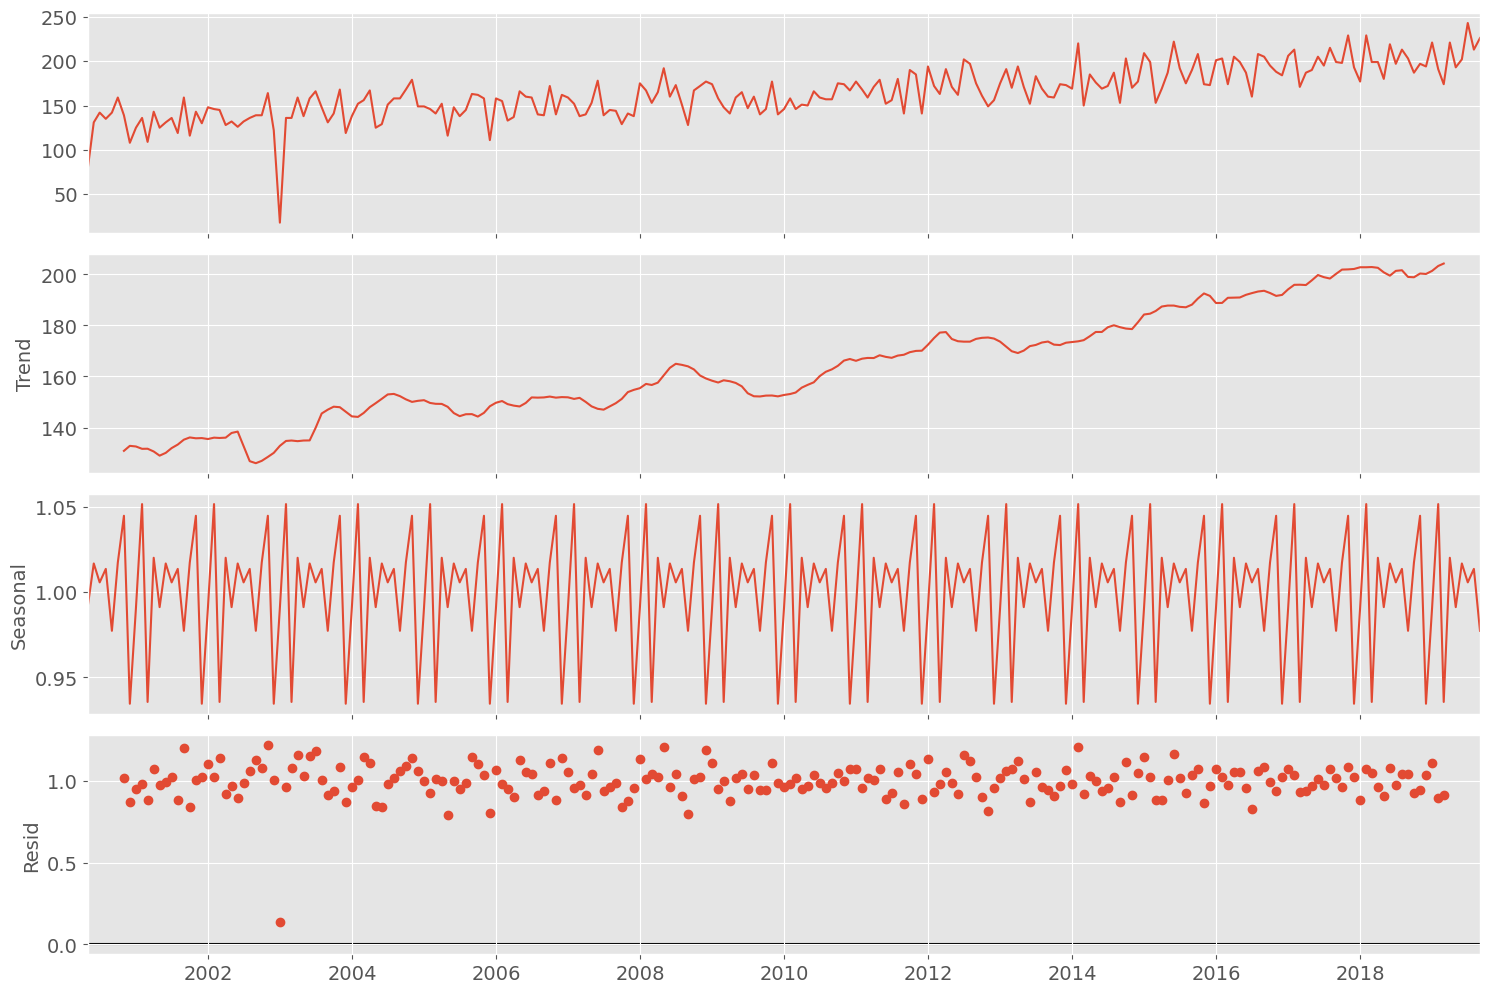

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose

calls = calls_data[calls_data["Call Date"]!=np.nan].groupby("Call Date").agg({"Call Number":"count"})
g=calls.groupby(pd.Grouper(freq="M"))
decompose_result_mult = seasonal_decompose(g.sum(), model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [77]:
calls_geo_data=calls_data[["lat","long"]]
calls_geo_data["lat"] = calls_geo_data["lat"].astype(float) 
calls_geo_data["long"] = calls_geo_data["long"].astype(float) 

C:\Users\Mahmo\AppData\Local\Temp\ipykernel_14328\2806265445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_geo_data["lat"] = calls_geo_data["lat"].astype(float)
C:\Users\Mahmo\AppData\Local\Temp\ipykernel_14328\2806265445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_geo_data["long"] = calls_geo_data["long"].astype(float)


In [78]:
from sklearn.cluster import KMeans
kmeans = KMeans(
    init="random",
    n_clusters=16,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [79]:
kmeans.fit(calls_geo_data)
labels = kmeans.labels_
calls_geo_data['cluster'] = labels
clusters = calls_geo_data.groupby('cluster')['lat'].count()


C:\Users\Mahmo\AppData\Local\Temp\ipykernel_14328\4153436019.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_geo_data['cluster'] = labels


In [80]:
centers=[]
for i in range(len(clusters)):
    calls=calls_geo_data[calls_geo_data["cluster"]==i]
    centers.append([calls["lat"].mean(),calls["long"].mean()])
    

In [81]:
for point in range(0, len(centers)):
    folium.Marker(centers[point]).add_to(zip_calls_map)
zip_calls_map